# 前半

In [2]:
from gensim.models import KeyedVectors

file = '../CH7 Word-embedding/GoogleNews-vectors-negative300.bin.gz'
model = KeyedVectors.load_word2vec_format(file, binary=True)

# データのロード
import pandas as pd
import re
import numpy as np

# ファイル読み込み
file = '../CH6 Machine-learning/newsCorpora.csv'
data = pd.read_csv(file, encoding='utf-8', header=None, sep='\t', names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])
data = data.replace('"', "'")
# 特定のpublisherのみ抽出
publishers = ['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']
data = data.loc[data['PUBLISHER'].isin(publishers), ['TITLE', 'CATEGORY']].reset_index(drop=True)

# 学習用、検証用、評価用に分割する
from sklearn.model_selection import train_test_split

train, valid_test = train_test_split(data, test_size=0.2, shuffle=True, random_state=64, stratify=data['CATEGORY'])
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True, random_state=64, stratify=valid_test['CATEGORY'])

train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)
test = test.reset_index(drop=True)

# データ数の確認
print('学習データ')
print(train['CATEGORY'].value_counts())
print('検証データ')
print(valid['CATEGORY'].value_counts())
print('評価データ')
print(test['CATEGORY'].value_counts())

import re

# データの結合
df = pd.concat([train, valid, test], axis=0).reset_index(drop=True)

# 前処理
def preprocessing(text):
    text_clean = re.sub(r'[\"\'.,:;\(\)#\|\*\+\!\?#$%&/\]\[\{\}]', '', text)
    text_clean = re.sub('[0-9]+', '0', text_clean)
    text_clean = re.sub('\s-\s', ' ', text_clean)
    return text_clean

df['TITLE'] = df['TITLE'].apply(preprocessing)

学習データ
b    4502
e    4223
t    1219
m     728
Name: CATEGORY, dtype: int64
検証データ
b    562
e    528
t    153
m     91
Name: CATEGORY, dtype: int64
評価データ
b    563
e    528
t    152
m     91
Name: CATEGORY, dtype: int64


In [3]:
import numpy as np
# 平均単語ベクトルの取得
def w2v(text):
    words = text.rstrip().split()
    vec = [model[word] for word in words if word in model]
    return np.array(sum(vec) / len(vec))

vecs = np.array([])
for text in df['TITLE']:
    if len(vecs) == 0:
        vecs = w2v(text)
    else:
        vecs = np.vstack([vecs, w2v(text)])

# 特徴ベクトルのテンソル化
import torch

# 乱数のシードを設定
torch.manual_seed(1234)
np.random.seed(1234)

X_train = torch.from_numpy(vecs[:len(train), :])
X_valid = torch.from_numpy(vecs[len(train):len(train)+ len(valid), :])
X_test = torch.from_numpy(vecs[len(train)+ len(valid):, :])
print(X_train.size())
print(X_train)


torch.Size([10672, 300])
tensor([[ 0.0368,  0.0300, -0.0738,  ..., -0.1523,  0.0419, -0.0774],
        [ 0.0002, -0.0056, -0.0824,  ..., -0.0544,  0.0776, -0.0214],
        [ 0.0266, -0.0166, -0.0877,  ..., -0.0522,  0.0517,  0.0093],
        ...,
        [-0.0291,  0.0529, -0.1453,  ...,  0.0494,  0.1548, -0.0910],
        [-0.0269,  0.1204, -0.0289,  ..., -0.0062,  0.0739, -0.0327],
        [ 0.0361,  0.1236,  0.0260,  ..., -0.0099, -0.0193,  0.0262]])


In [4]:
# ターゲットのテンソル化
category_dict = {'b': 0, 't': 1, 'e':2, 'm':3}
Y_train = torch.from_numpy(train['CATEGORY'].map(category_dict).values)
Y_valid = torch.from_numpy(valid['CATEGORY'].map(category_dict).values)
Y_test = torch.from_numpy(test['CATEGORY'].map(category_dict).values)
# 保存
torch.save(X_train, 'X_train.pt')
torch.save(X_valid, 'X_valid.pt')
torch.save(X_test, 'X_test.pt')
torch.save(Y_train, 'y_train.pt')
torch.save(Y_valid, 'y_valid.pt')
torch.save(Y_test, 'y_test.pt')

In [5]:
# モデルの構築
from torch import nn

class SLNet(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.fc = nn.Linear(input_size, output_size)
    
    def forward(self, x):
        logits = self.fc(x)
        return logits

model = SLNet(300, 4)
print(model)

SLNet(
  (fc): Linear(in_features=300, out_features=4, bias=True)
)


In [6]:
logits = model(X_train[0])
y_hat_1 = nn.Softmax(dim=-1)(logits)
print(logits)
print(y_hat_1)

tensor([-0.0176,  0.0697,  0.0920,  0.0596], grad_fn=<AddBackward0>)
tensor([0.2332, 0.2545, 0.2603, 0.2520], grad_fn=<SoftmaxBackward0>)


In [7]:
logits = model(X_train[:4])
Y_hat = nn.Softmax(dim=1)(logits)
print(logits)
print(Y_hat)

tensor([[-0.0176,  0.0697,  0.0920,  0.0596],
        [-0.0210,  0.0704,  0.0814,  0.0636],
        [ 0.0360,  0.1010,  0.0704,  0.0456],
        [ 0.0362,  0.1266,  0.0222,  0.1343]], grad_fn=<AddmmBackward0>)
tensor([[0.2332, 0.2545, 0.2603, 0.2520],
        [0.2330, 0.2553, 0.2581, 0.2536],
        [0.2432, 0.2595, 0.2517, 0.2455],
        [0.2390, 0.2616, 0.2357, 0.2637]], grad_fn=<SoftmaxBackward0>)


In [8]:
# x_1のロスを求める
criterion = nn.CrossEntropyLoss()
logits = model(X_train[:4])
loss = criterion(logits, Y_train[:4])
print("損失: ", loss.item())
model.zero_grad()
loss.backward()
print("勾配: ")
print(model.fc.weight.grad)

損失:  1.3807432651519775


勾配: 
tensor([[ 5.0444e-03,  3.9170e-03,  7.1611e-03,  ..., -2.0513e-03,
         -4.2177e-03,  5.3509e-04],
        [ 3.9538e-05, -6.0439e-03, -1.8717e-02,  ..., -1.5257e-02,
         -4.6948e-03, -6.8699e-03],
        [-1.0491e-02, -7.2170e-04,  2.5712e-02,  ...,  3.4016e-02,
         -7.4130e-03,  1.1578e-02],
        [ 5.4069e-03,  2.8486e-03, -1.4156e-02,  ..., -1.6707e-02,
          1.6325e-02, -5.2435e-03]])


In [9]:
# データセットを作成する
import torch.utils.data as data

class NewsDataset(data.Dataset):
    """
    newsのDatasetクラス
    
    Attributes
    ----------------------------
    X : テンソル
        単語ベクトルの平均をまとめたテンソル
    y : テンソル
        カテゴリをラベル化したテンソル
    phase : 'train' or 'val'
        学習か訓練かを設定する
    """
    def __init__(self, X, y, phase='train'):
        self.X = X
        self.y = y
        self.phase = phase
    
    def __len__(self):
        """全データサイズを返す"""
        return len(self.y)
    
    def __getitem__(self, idx):
        """idxに対応するテンソル形式のデータとラベルを取得"""
        return self.X[idx], self.y[idx]

train_dataset = NewsDataset(X_train, Y_train, phase='train')
valid_dataset = NewsDataset(X_valid, Y_valid, phase='val')
test_dataset = NewsDataset(X_test, Y_test, phase='val')

# 動作確認
idx = 0
print(train_dataset.__getitem__(idx)[0].size())
print(train_dataset.__getitem__(idx)[1])
print(valid_dataset.__getitem__(idx)[0].size())
print(valid_dataset.__getitem__(idx)[1])
print(test_dataset.__getitem__(idx)[0].size())
print(test_dataset.__getitem__(idx)[1])


torch.Size([300])
tensor(2)
torch.Size([300])
tensor(3)
torch.Size([300])
tensor(2)


In [10]:
# DataLoaderを作成
batch_size = 1

train_dataloader = data.DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = data.DataLoader(
            valid_dataset, batch_size=len(valid_dataset), shuffle=False)
test_dataloader = data.DataLoader(
            test_dataset, batch_size=len(test_dataset), shuffle=False)

dataloaders_dict = {'train': train_dataloader,
                    'val': valid_dataloader,
                    'test': test_dataloader,
                   }

# 動作確認
batch_iter = iter(dataloaders_dict['train'])
inputs, labels = next(batch_iter)
print(inputs.size())
print(labels)

torch.Size([1, 300])
tensor([2])


In [12]:
from tqdm import tqdm
# 学習

# モデルの定義
net = SLNet(300, 4)
net.train()

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# 最適化手法の定義
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

# 学習用の関数を定義
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    
    # epochのループ
    for epoch in range(num_epochs):
        print('Epoch {} / {}'.format(epoch + 1, num_epochs))
        print('--------------------------------------------')
        
        # epochごとの学習と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train() # 訓練モード
            else:
                net.eval() # 検証モード
            
            epoch_loss = 0.0 # epochの損失和
            epoch_corrects = 0 # epochの正解数
            
            # データローダーからミニバッチを取り出すループ
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                optimizer.zero_grad() # optimizerを初期化
                
                # 順伝播計算(forward)
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels) # 損失を計算
                    _, preds = torch.max(outputs, 1) # ラベルを予想
                    
                    # 訓練時は逆伝播
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                    # イテレーション結果の計算
                    # lossの合計を更新
                    epoch_loss += loss.item() * inputs.size(0)
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)
            
            # epochごとのlossと正解率の表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)
            
            print('{} Loss: {:.4f}, Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            
# 学習を実行する
num_epochs = 10
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 1 / 10
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 2905.03it/s]


train Loss: 0.4172, Acc: 0.8584


100%|██████████| 1/1 [00:00<00:00, 79.37it/s]


val Loss: 0.3073, Acc: 0.9018
Epoch 2 / 10
--------------------------------------------


100%|██████████| 10672/10672 [00:05<00:00, 2105.14it/s]


train Loss: 0.3117, Acc: 0.8936


100%|██████████| 1/1 [00:00<00:00, 21.41it/s]


val Loss: 0.2807, Acc: 0.9093
Epoch 3 / 10
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3458.99it/s]


train Loss: 0.2913, Acc: 0.9004


100%|██████████| 1/1 [00:00<00:00, 13.89it/s]


val Loss: 0.2806, Acc: 0.9070
Epoch 4 / 10
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3514.14it/s]


train Loss: 0.2779, Acc: 0.9033


100%|██████████| 1/1 [00:00<00:00, 48.76it/s]


val Loss: 0.2759, Acc: 0.9040
Epoch 5 / 10
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 2748.37it/s]


train Loss: 0.2708, Acc: 0.9056


100%|██████████| 1/1 [00:00<00:00, 35.92it/s]


val Loss: 0.2719, Acc: 0.9130
Epoch 6 / 10
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3195.54it/s]


train Loss: 0.2661, Acc: 0.9075


100%|██████████| 1/1 [00:00<00:00, 91.57it/s]


val Loss: 0.2692, Acc: 0.9153
Epoch 7 / 10
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3487.45it/s]


train Loss: 0.2609, Acc: 0.9110


100%|██████████| 1/1 [00:00<00:00, 134.72it/s]


val Loss: 0.2696, Acc: 0.9153
Epoch 8 / 10
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3465.98it/s]


train Loss: 0.2567, Acc: 0.9129


100%|██████████| 1/1 [00:00<00:00, 19.94it/s]


val Loss: 0.2808, Acc: 0.9108
Epoch 9 / 10
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3453.71it/s]


train Loss: 0.2554, Acc: 0.9122


100%|██████████| 1/1 [00:00<00:00, 12.18it/s]


val Loss: 0.2712, Acc: 0.9130
Epoch 10 / 10
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3442.18it/s]


train Loss: 0.2520, Acc: 0.9136


100%|██████████| 1/1 [00:00<00:00, 16.43it/s]

val Loss: 0.2788, Acc: 0.9055


In [13]:
def calc_acc(net, dataloader):
    net.eval()
    corrects = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = net(inputs)
            _, preds = torch.max(outputs, 1) # ラベルを予想
            corrects += torch.sum(preds == labels.data)
    return corrects / len(dataloader.dataset)

acc_train = calc_acc(net, train_dataloader)
acc_valid = calc_acc(net, valid_dataloader)
acc_test = calc_acc(net, test_dataloader)
print('学習データの正解率: {:.4f}'.format(acc_train))
print('検証データの正解率: {:.4f}'.format(acc_valid))
print('テストデータの正解率: {:.4f}'.format(acc_test))

学習データの正解率: 0.9142
検証データの正解率: 0.9055
テストデータの正解率: 0.8891


In [14]:
def calc_acc(net, dataloader):
    net.eval()
    corrects = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = net(inputs)
            _, preds = torch.max(outputs, 1) # ラベルを予想
            corrects += torch.sum(preds == labels.data)
    return corrects / len(dataloader.dataset)

acc_train = calc_acc(net, train_dataloader)
acc_valid = calc_acc(net, valid_dataloader)
acc_test = calc_acc(net, test_dataloader)
print('学習データの正解率: {:.4f}'.format(acc_train))
print('検証データの正解率: {:.4f}'.format(acc_valid))
print('テストデータの正解率: {:.4f}'.format(acc_test))

学習データの正解率: 0.9142
検証データの正解率: 0.9055
テストデータの正解率: 0.8891


In [16]:
# 学習用の関数を定義
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []
    # epochのループ
    for epoch in range(num_epochs):
        print('Epoch {} / {}'.format(epoch + 1, num_epochs))
        print('--------------------------------------------')
        
        # epochごとの学習と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train() # 訓練モード
            else:
                net.eval() # 検証モード
            
            epoch_loss = 0.0 # epochの損失和
            epoch_corrects = 0 # epochの正解数
            
            # データローダーからミニバッチを取り出すループ
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                optimizer.zero_grad() # optimizerを初期化
                
                # 順伝播計算(forward)
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels) # 損失を計算
                    _, preds = torch.max(outputs, 1) # ラベルを予想
                    
                    # 訓練時は逆伝播
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                    # イテレーション結果の計算
                    # lossの合計を更新
                    epoch_loss += loss.item() * inputs.size(0)
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)
            
            # epochごとのlossと正解率の表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)
            
            print('{} Loss: {:.4f}, Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
        
        # チェックポイントの保存
        torch.save({'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict()
                   },
                   'checkpoints/checkpoint{}.pt'.format(epoch + 1))
    return train_loss, train_acc, valid_loss, valid_acc

# 学習を実行する

# モデルの定義
net = SLNet(300, 4)
net.train()

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# 最適化手法の定義
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

num_epochs = 10
train_loss, train_acc, valid_loss, valid_acc = train_model(net,
            dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 1 / 10
--------------------------------------------


100%|██████████| 10672/10672 [00:05<00:00, 2132.71it/s]


train Loss: 0.4136, Acc: 0.8624


100%|██████████| 1/1 [00:00<00:00, 16.36it/s]


val Loss: 0.3046, Acc: 0.9048
Epoch 2 / 10
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 2800.44it/s]


train Loss: 0.3100, Acc: 0.8931


100%|██████████| 1/1 [00:00<00:00, 136.04it/s]


val Loss: 0.2909, Acc: 0.9070
Epoch 3 / 10
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3479.82it/s]


train Loss: 0.2903, Acc: 0.8984


100%|██████████| 1/1 [00:00<00:00, 34.33it/s]


val Loss: 0.2763, Acc: 0.9130
Epoch 4 / 10
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3062.26it/s]


train Loss: 0.2772, Acc: 0.9059


100%|██████████| 1/1 [00:00<00:00, 11.13it/s]


val Loss: 0.2728, Acc: 0.9108
Epoch 5 / 10
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3399.78it/s]


train Loss: 0.2707, Acc: 0.9055


100%|██████████| 1/1 [00:00<00:00, 134.39it/s]


val Loss: 0.2662, Acc: 0.9115
Epoch 6 / 10
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3463.07it/s]


train Loss: 0.2656, Acc: 0.9087


100%|██████████| 1/1 [00:00<00:00, 126.56it/s]


val Loss: 0.2756, Acc: 0.9093
Epoch 7 / 10
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3470.36it/s]


train Loss: 0.2615, Acc: 0.9118


100%|██████████| 1/1 [00:00<00:00, 24.75it/s]


val Loss: 0.2743, Acc: 0.9115
Epoch 8 / 10
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3474.49it/s]


train Loss: 0.2566, Acc: 0.9114


100%|██████████| 1/1 [00:00<00:00, 137.21it/s]


val Loss: 0.2692, Acc: 0.9115
Epoch 9 / 10
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3455.93it/s]


train Loss: 0.2553, Acc: 0.9119


100%|██████████| 1/1 [00:00<00:00, 56.63it/s]


val Loss: 0.2720, Acc: 0.9115
Epoch 10 / 10
--------------------------------------------


100%|██████████| 10672/10672 [00:03<00:00, 3419.97it/s]


train Loss: 0.2533, Acc: 0.9100


100%|██████████| 1/1 [00:00<00:00, 141.38it/s]

val Loss: 0.2765, Acc: 0.9115


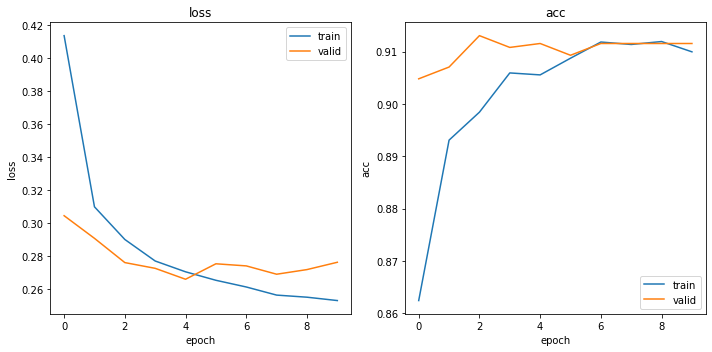

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize=(10, 5))
epochs = np.arange(num_epochs)
ax[0].plot(epochs, train_loss, label='train')
ax[0].plot(epochs, valid_loss, label='valid')
ax[0].set_title('loss')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[1].plot(epochs, train_acc, label='train')
ax[1].plot(epochs, valid_acc, label='valid')
ax[1].set_title('acc')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('acc')
ax[0].legend(loc='best')
ax[1].legend(loc='best')
plt.tight_layout()
plt.savefig('fig74.png')

# 後半

In [18]:
# MINIBATCH

import time

# 学習用の関数を定義
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    
    # 初期設定
    # GPUが使えるか確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス:", device)
    
    # ネットワークをgpuへ
    net.to(device)
    
    # ネットワークがある程度固定なら高速化させる
    torch.backends.cudnn.benchmark = True
    
    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []
    # epochのループ
    for epoch in range(num_epochs):
        # 開始時刻の記録
        start = time.time()
        print('Epoch {} / {}'.format(epoch + 1, num_epochs))
        print('--------------------------------------------')
        
        # epochごとの学習と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train() # 訓練モード
            else:
                net.eval() # 検証モード
            
            epoch_loss = 0.0 # epochの損失和
            epoch_corrects = 0 # epochの正解数
            
            # データローダーからミニバッチを取り出すループ
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                # GPUが使えるならGPUにおっくる
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad() # optimizerを初期化
                
                # 順伝播計算(forward)
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels) # 損失を計算
                    _, preds = torch.max(outputs, 1) # ラベルを予想
                    
                    # 訓練時は逆伝播
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                    # イテレーション結果の計算
                    # lossの合計を更新
                    epoch_loss += loss.item() * inputs.size(0)
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)
            
            # epochごとのlossと正解率の表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)
            
            print('{} Loss: {:.4f}, Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
        # 修了時刻の記録
        end = time.time()
        calc_time = end - start
        print('batch_size {} calc_time: {:.4f} sec'.format(batch_size, calc_time))
    return train_loss, train_acc, valid_loss, valid_acc, calc_time


# 学習を実行する
batch_sizes = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]
cpu_times = []
for batch_size in batch_sizes:
    print('batch_size: {}'.format(batch_size))
    # DataLoaderを作成
    train_dataloader = data.DataLoader(
                train_dataset, batch_size=batch_size, shuffle=True)
    valid_dataloader = data.DataLoader(
                valid_dataset, batch_size=len(valid_dataset), shuffle=False)
    test_dataloader = data.DataLoader(
                test_dataset, batch_size=len(test_dataset), shuffle=False)

    dataloaders_dict = {'train': train_dataloader,
                        'val': valid_dataloader,
                        'test': test_dataloader,
                       }
    # モデルの定義
    net = SLNet(300, 4)
    net.train()

    # 損失関数の定義
    criterion = nn.CrossEntropyLoss()

    # 最適化手法の定義
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

    num_epochs = 1
    train_loss, train_acc, valid_loss, valid_acc, calc_time = \
                        train_model(net, dataloaders_dict, criterion, optimizer,
                                    num_epochs=num_epochs)
    cpu_times.append(calc_time)

batch_size: 1
使用デバイス: cuda:0
Epoch 1 / 1
--------------------------------------------


100%|██████████| 10672/10672 [00:15<00:00, 703.71it/s]


train Loss: 0.4165, Acc: 0.8585


100%|██████████| 1/1 [00:00<00:00, 54.66it/s]


val Loss: 0.3075, Acc: 0.9010
batch_size 1 calc_time: 15.1989 sec
batch_size: 2
使用デバイス: cuda:0
Epoch 1 / 1
--------------------------------------------


100%|██████████| 5336/5336 [00:07<00:00, 738.56it/s]


train Loss: 0.4765, Acc: 0.8392


100%|██████████| 1/1 [00:00<00:00,  6.89it/s]


val Loss: 0.3475, Acc: 0.8891
batch_size 2 calc_time: 7.3821 sec
batch_size: 4
使用デバイス: cuda:0
Epoch 1 / 1
--------------------------------------------


100%|██████████| 2668/2668 [00:03<00:00, 716.10it/s]


train Loss: 0.5586, Acc: 0.8177


100%|██████████| 1/1 [00:00<00:00, 72.59it/s]


val Loss: 0.4071, Acc: 0.8733
batch_size 4 calc_time: 3.7505 sec
batch_size: 8
使用デバイス: cuda:0
Epoch 1 / 1
--------------------------------------------


100%|██████████| 1334/1334 [00:01<00:00, 697.57it/s]


train Loss: 0.6593, Acc: 0.7852


100%|██████████| 1/1 [00:00<00:00, 68.44it/s]


val Loss: 0.4925, Acc: 0.8306
batch_size 8 calc_time: 1.9384 sec
batch_size: 16
使用デバイス: cuda:0
Epoch 1 / 1
--------------------------------------------


100%|██████████| 667/667 [00:01<00:00, 645.36it/s]


train Loss: 0.7667, Acc: 0.7583


100%|██████████| 1/1 [00:00<00:00, 88.95it/s]


val Loss: 0.5958, Acc: 0.7894
batch_size 16 calc_time: 1.0590 sec
batch_size: 32
使用デバイス: cuda:0
Epoch 1 / 1
--------------------------------------------


100%|██████████| 334/334 [00:00<00:00, 593.83it/s]


train Loss: 0.8855, Acc: 0.7550


100%|██████████| 1/1 [00:00<00:00, 86.30it/s]


val Loss: 0.7093, Acc: 0.7834
batch_size 32 calc_time: 0.5849 sec
batch_size: 64
使用デバイス: cuda:0
Epoch 1 / 1
--------------------------------------------


100%|██████████| 167/167 [00:00<00:00, 508.99it/s]


train Loss: 1.0014, Acc: 0.7343


100%|██████████| 1/1 [00:00<00:00, 84.26it/s]


val Loss: 0.8336, Acc: 0.7796
batch_size 64 calc_time: 0.3513 sec
batch_size: 128
使用デバイス: cuda:0
Epoch 1 / 1
--------------------------------------------


100%|██████████| 84/84 [00:00<00:00, 419.88it/s]


train Loss: 1.1298, Acc: 0.6264


100%|██████████| 1/1 [00:00<00:00, 68.26it/s]


val Loss: 0.9614, Acc: 0.7699
batch_size 128 calc_time: 0.2254 sec
batch_size: 256
使用デバイス: cuda:0
Epoch 1 / 1
--------------------------------------------


100%|██████████| 42/42 [00:00<00:00, 286.78it/s]


train Loss: 1.2228, Acc: 0.5971


100%|██████████| 1/1 [00:00<00:00, 90.19it/s]


val Loss: 1.0745, Acc: 0.7721
batch_size 256 calc_time: 0.1696 sec
batch_size: 512
使用デバイス: cuda:0
Epoch 1 / 1
--------------------------------------------


100%|██████████| 21/21 [00:00<00:00, 189.87it/s]


train Loss: 1.3136, Acc: 0.4623


100%|██████████| 1/1 [00:00<00:00, 92.58it/s]


val Loss: 1.2002, Acc: 0.7151
batch_size 512 calc_time: 0.1313 sec
batch_size: 1024
使用デバイス: cuda:0
Epoch 1 / 1
--------------------------------------------


100%|██████████| 11/11 [00:00<00:00, 118.05it/s]


train Loss: 1.3614, Acc: 0.3602


100%|██████████| 1/1 [00:00<00:00, 70.93it/s]


val Loss: 1.3005, Acc: 0.6514
batch_size 1024 calc_time: 0.1185 sec
batch_size: 2048
使用デバイス: cuda:0
Epoch 1 / 1
--------------------------------------------


100%|██████████| 6/6 [00:00<00:00, 65.67it/s]


train Loss: 1.4040, Acc: 0.1493


100%|██████████| 1/1 [00:00<00:00, 96.12it/s]

val Loss: 1.3749, Acc: 0.3426
batch_size 2048 calc_time: 0.1132 sec


In [19]:
class MLNet(nn.Module):
    def __init__(self, input_size, mid_size, output_size):
        super().__init__()
        self.layers = nn.Sequential(
                    nn.Linear(input_size, mid_size),
                    nn.BatchNorm1d(mid_size),
                    nn.ReLU(),
                    nn.Linear(mid_size, mid_size),
                    nn.BatchNorm1d(mid_size),
                    nn.ReLU(),
                    nn.Linear(mid_size, output_size),
                    )
    
    def forward(self, x):
        logits = self.layers(x)
        return logits

net = MLNet(300, 256, 4)
print(net)

MLNet(
  (layers): Sequential(
    (0): Linear(in_features=300, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=4, bias=True)
  )
)


In [20]:
# 学習用の関数を定義
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    
    # 初期設定
    # GPUが使えるか確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス:", device)
    
    # ネットワークをgpuへ
    net.to(device)
    
    # ネットワークがある程度固定なら高速化させる
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs, eta_min=1e-6, last_epoch=-1)
    
    # epochのループ
    for epoch in range(num_epochs):
        # epochごとの学習と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train() # 訓練モード
            else:
                net.eval() # 検証モード
            
            epoch_loss = 0.0 # epochの損失和
            epoch_corrects = 0 # epochの正解数
            
            # データローダーからミニバッチを取り出すループ
            for inputs, labels in dataloaders_dict[phase]:
                # GPUが使えるならGPUにおっくる
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad() # optimizerを初期化
                
                # 順伝播計算(forward)
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels) # 損失を計算
                    _, preds = torch.max(outputs, 1) # ラベルを予想
                    
                    # 訓練時は逆伝播
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                    # イテレーション結果の計算
                    # lossの合計を更新
                    epoch_loss += loss.item() * inputs.size(0)
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)
            
            # epochごとのlossと正解率の表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc.cpu())
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc.cpu())
            
        print('Epoch {} / {} (train) Loss: {:.4f}, Acc: {:.4f}, (val) Loss: {:.4f}, Acc: {:.4f}'.format(epoch + 1, num_epochs, train_loss[-1], train_acc[-1], valid_loss[-1], valid_acc[-1]))
        scheduler.step()
    return train_loss, train_acc, valid_loss, valid_acc

batch_size = 2048
num_epochs = 200

# DataLoaderを作成
train_dataloader = data.DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = data.DataLoader(
            valid_dataset, batch_size=len(valid_dataset), shuffle=False)
test_dataloader = data.DataLoader(
            test_dataset, batch_size=len(test_dataset), shuffle=False)

dataloaders_dict = {'train': train_dataloader,
                    'val': valid_dataloader,
                    'test': test_dataloader,
                   }
# モデルの定義
net = MLNet(300, 256, 4)
net.train()

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# 最適化手法の定義
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

train_loss, train_acc, valid_loss, valid_acc = \
            train_model(net, dataloaders_dict, criterion, optimizer,
                        num_epochs=num_epochs)

使用デバイス: cuda:0
Epoch 1 / 200 (train) Loss: 1.4257, Acc: 0.3041, (val) Loss: 1.3995, Acc: 0.1199
Epoch 2 / 200 (train) Loss: 1.1723, Acc: 0.5401, (val) Loss: 1.3808, Acc: 0.3051
Epoch 3 / 200 (train) Loss: 0.9774, Acc: 0.7099, (val) Loss: 1.3388, Acc: 0.4573
Epoch 4 / 200 (train) Loss: 0.8325, Acc: 0.7767, (val) Loss: 1.2701, Acc: 0.4640
Epoch 5 / 200 (train) Loss: 0.7276, Acc: 0.8088, (val) Loss: 1.1753, Acc: 0.6154
Epoch 6 / 200 (train) Loss: 0.6512, Acc: 0.8248, (val) Loss: 1.0577, Acc: 0.7279
Epoch 7 / 200 (train) Loss: 0.5939, Acc: 0.8378, (val) Loss: 0.9248, Acc: 0.7856
Epoch 8 / 200 (train) Loss: 0.5506, Acc: 0.8489, (val) Loss: 0.7887, Acc: 0.8231
Epoch 9 / 200 (train) Loss: 0.5159, Acc: 0.8567, (val) Loss: 0.6687, Acc: 0.8381
Epoch 10 / 200 (train) Loss: 0.4874, Acc: 0.8630, (val) Loss: 0.5753, Acc: 0.8516
Epoch 11 / 200 (train) Loss: 0.4628, Acc: 0.8684, (val) Loss: 0.5093, Acc: 0.8636
Epoch 12 / 200 (train) Loss: 0.4426, Acc: 0.8727, (val) Loss: 0.4652, Acc: 0.8696
Epoch 13 /

学習データの正解率: 0.9891
検証データの正解率: 0.9115
テストデータの正解率: 0.9063


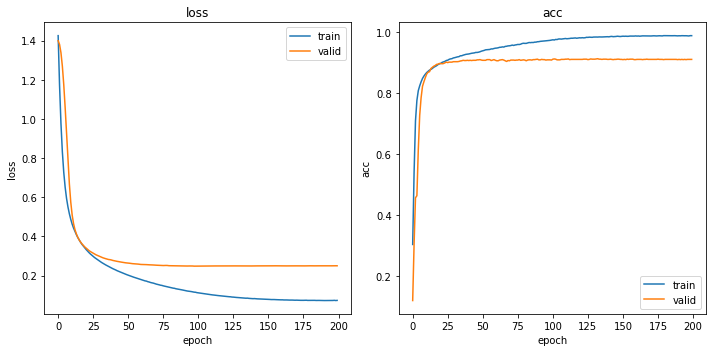

In [21]:
def calc_acc(net, dataloader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.eval()
    corrects = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = net(inputs)
            _, preds = torch.max(outputs, 1) # ラベルを予想
            corrects += torch.sum(preds == labels.data).cpu()
    return corrects / len(dataloader.dataset)

acc_train = calc_acc(net, train_dataloader)
acc_valid = calc_acc(net, valid_dataloader)
acc_test = calc_acc(net, test_dataloader)
print('学習データの正解率: {:.4f}'.format(acc_train))
print('検証データの正解率: {:.4f}'.format(acc_valid))
print('テストデータの正解率: {:.4f}'.format(acc_test))

fig, ax = plt.subplots(1,2, figsize=(10, 5))
epochs = np.arange(num_epochs)
ax[0].plot(epochs, train_loss, label='train')
ax[0].plot(epochs, valid_loss, label='valid')
ax[0].set_title('loss')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[1].plot(epochs, train_acc, label='train')
ax[1].plot(epochs, valid_acc, label='valid')
ax[1].set_title('acc')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('acc')
ax[0].legend(loc='best')
ax[1].legend(loc='best')
plt.tight_layout()
plt.savefig('fig79.png')
plt.show()